
✅ Forecast complete for 'MONTEMAC FX TAB'!
📊 Next 8 Weeks Prediction:

    Week  Predicted_Quantity
2025-W43                  81
2025-W44                  39
2025-W45                  66
2025-W46                  67
2025-W47                  46
2025-W48                  69
2025-W49                  74
2025-W50                  64


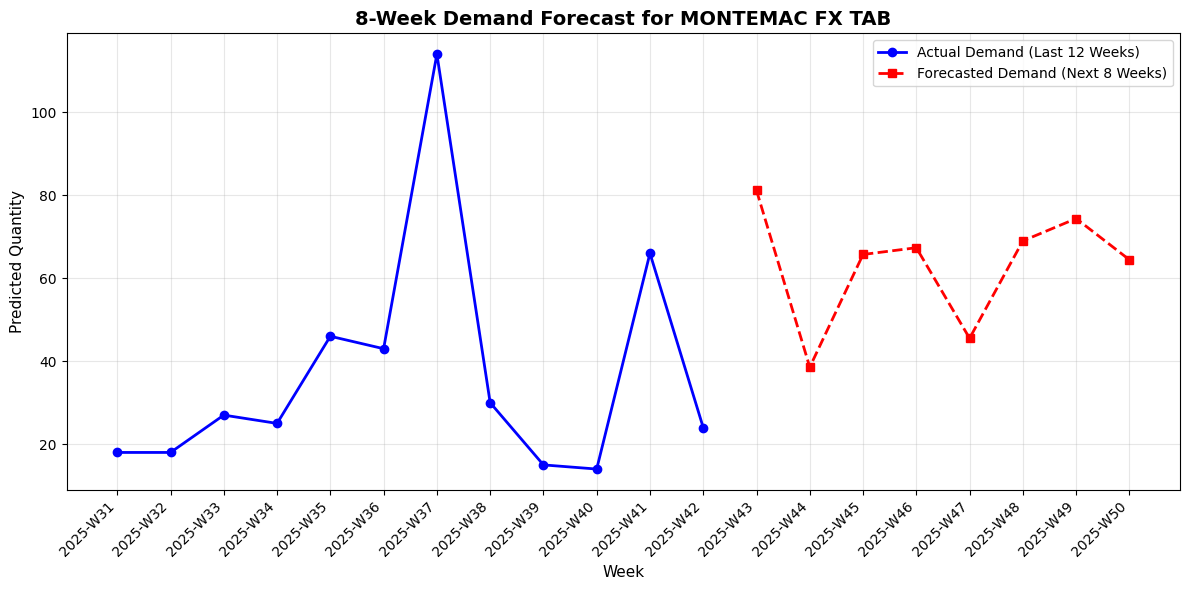

C:\Users\Strix\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


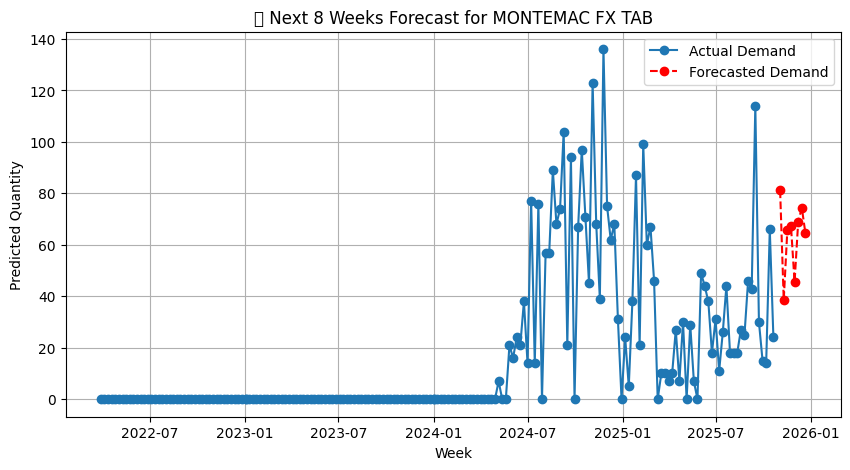


💾 Forecast saved to '../outputs/forecast_MONTEMAC_FX_TAB_8weeks_XGB.xlsx'


In [6]:
# ==============================================
# 📦 Predict Next 8 Weeks (~2 Months) with Iterative Lag Features
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import os

# ------------------- 1️⃣ Load Data -------------------
file_path = "../data/demand_prediction_weekly.xlsx"
df = pd.read_excel(file_path)

# 🧍 Ask user to enter medicine name
medicine_name = input("Enter the medicine name: ").strip()

if medicine_name not in df['Product_Name'].unique():
    print(f"❌ Medicine '{medicine_name}' not found in dataset!")
    print("Available medicines:\n", df['Product_Name'].unique())
    exit()

df_med = df[df['Product_Name'] == medicine_name].copy()
df_med = df_med.sort_values('Week').reset_index(drop=True)

# ✅ Convert 'Week' strings like '2025-W43' → actual datetime (Monday of that week)
df_med['Week'] = pd.to_datetime(df_med['Week'] + '-1', format='%Y-W%W-%w')

# ------------------- 2️⃣ Feature Engineering (Training Data) -------------------
df_med['Month'] = np.ceil(df_med['Week_Number'] / 4.33).astype(int).clip(upper=12)
df_med['Quarter'] = ((df_med['Month'] - 1) // 3 + 1).astype(int)
df_med['Is_Year_Start'] = (df_med['Week_Number'] <= 4).astype(int)
df_med['Is_Year_End'] = (df_med['Week_Number'] >= 48).astype(int)
df_med['Sin_Week'] = np.sin(2 * np.pi * df_med['Week_Number'] / 52)
df_med['Cos_Week'] = np.cos(2 * np.pi * df_med['Week_Number'] / 52)

# Lag features (12 weeks back)
for lag in range(1, 13):
    df_med[f'lag_{lag}'] = df_med['Total_Quantity'].shift(lag)

# Rolling statistics
df_med['rolling_mean_3'] = df_med['Total_Quantity'].shift(1).rolling(window=3).mean()
df_med['rolling_mean_5'] = df_med['Total_Quantity'].shift(1).rolling(window=5).mean()
df_med['rolling_mean_6'] = df_med['Total_Quantity'].shift(1).rolling(window=6).mean()
df_med['rolling_std_6'] = df_med['Total_Quantity'].shift(1).rolling(window=6).std()
df_med['rolling_mean_8'] = df_med['Total_Quantity'].shift(1).rolling(window=8).mean()
df_med['rolling_std_4'] = df_med['Total_Quantity'].shift(1).rolling(window=4).std()

df_med = df_med.dropna().reset_index(drop=True)

# ------------------- 3️⃣ Load Saved Model & Recreate Scaler -------------------
model = XGBRegressor()
model_dir = "../saved models"
model_path = os.path.join(model_dir, f"xgboost_{medicine_name}.json")
model.load_model(model_path)

# Recreate StandardScaler from training data
scaler = StandardScaler()
X_train = df_med.drop(columns=['Total_Quantity', 'Week', 'Product_Name'])
scaler.fit(X_train)

# Define feature columns
feature_cols = [c for c in df_med.columns 
                if c not in ['Total_Quantity', 'Week', 'Product_Name']]

# ------------------- 4️⃣ Prepare Initial Lag History -------------------
last_12_quantities = list(df_med['Total_Quantity'].astype(float).values[-12:][::-1])
last_row = df_med.iloc[-1].copy()
start_year = int(last_row['Year'])
start_week = int(last_row['Week_Number'])
last_date = df_med['Week'].iloc[-1]

# ------------------- 5️⃣ Iterative Forecasting -------------------
n_weeks = 8
predictions = []
pred_weeks = []
pred_dates = []

prev_qty = last_12_quantities.copy()

for i in range(n_weeks):
    # Calculate next week (with year rollover)
    wk = start_week + i + 1
    yr = start_year
    while wk > 52:
        wk -= 52
        yr += 1
    
    # Temporal features
    month = int(np.ceil(wk / 4.33))
    month = min(month, 12)
    quarter = ((month - 1) // 3) + 1
    is_year_start = int(wk <= 4)
    is_year_end = int(wk >= 48)
    sin_week = np.sin(2 * np.pi * wk / 52)
    cos_week = np.cos(2 * np.pi * wk / 52)
    
    # Lag features from previous predictions
    lags = {f'lag_{j}': (prev_qty[j-1] if j-1 < len(prev_qty) else 0.0) 
            for j in range(1, 13)}
    
    # Helper functions for safe rolling statistics
    def safe_mean(arr, k):
        if len(arr) < k:
            return float(np.mean(arr)) if len(arr) > 0 else 0.0
        return float(np.mean(arr[:k]))
    
    def safe_std(arr, k):
        if len(arr) < 2 or k < 2:
            return 0.0
        return float(np.std(arr[:k], ddof=1))
    
    # Rolling statistics based on previous values
    rm3 = safe_mean(prev_qty, 3)
    rm5 = safe_mean(prev_qty, 5)
    rm6 = safe_mean(prev_qty, 6)
    rs6 = safe_std(prev_qty, 6)
    rm8 = safe_mean(prev_qty, 8)
    rs4 = safe_std(prev_qty, 4)
    
    # Build feature row
    row = {
        'Year': yr,
        'Week_Number': wk,
        'Month': month,
        'Quarter': quarter,
        'Is_Year_Start': is_year_start,
        'Is_Year_End': is_year_end,
        'Sin_Week': sin_week,
        'Cos_Week': cos_week,
        **lags,
        'rolling_mean_3': rm3,
        'rolling_mean_5': rm5,
        'rolling_mean_6': rm6,
        'rolling_std_6': rs6,
        'rolling_mean_8': rm8,
        'rolling_std_4': rs4
    }
    
    # Create DataFrame with correct column order
    row_df = pd.DataFrame([row])
    row_df = row_df[feature_cols]
    
    # Make prediction (apply scaler)
    X_input = scaler.transform(row_df)
    pred = model.predict(X_input)[0]
    
    predictions.append(float(pred))
    pred_weeks.append(f"{yr}-W{wk:02d}")
    pred_dates.append(last_date + pd.Timedelta(weeks=i+1))
    
    # Update lag history: insert prediction at front, keep last 12
    prev_qty.insert(0, float(pred))
    prev_qty = prev_qty[:12]

# ------------------- 6️⃣ Display Results -------------------
future_df = pd.DataFrame({
    'Week': pred_weeks,
    'Predicted_Quantity': [int(round(p)) for p in predictions]
})

print(f"\n✅ Forecast complete for '{medicine_name}'!")
print(f"📊 Next {n_weeks} Weeks Prediction:\n")
print(future_df.to_string(index=False))

# ------------------- 7️⃣ Plot (Last 12 weeks + Next 8 weeks) -------------------
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual data (last 12 weeks)
last_12_dates = df_med['Week'].iloc[-12:].values
last_12_actuals = df_med['Total_Quantity'].iloc[-12:].values
ax.plot(last_12_dates, last_12_actuals, marker='o', label='Actual Demand (Last 12 Weeks)', 
        linewidth=2, markersize=6, color='blue')

# Plot forecasted data
ax.plot(pred_dates, predictions, marker='s', linestyle='--', label='Forecasted Demand (Next 8 Weeks)',
        linewidth=2, markersize=6, color='red')

# Extract week numbers from last 12 weeks
last_12_weeks = [f"{int(yr)}-W{int(wk):02d}" for yr, wk in 
                 zip(df_med['Year'].iloc[-12:].values, df_med['Week_Number'].iloc[-12:].values)]

# Combine all labels
all_dates = list(last_12_dates) + list(pred_dates)
all_labels = last_12_weeks + pred_weeks

ax.set_xticks(all_dates)
ax.set_xticklabels(all_labels, rotation=45, ha='right')

ax.set_title(f"8-Week Demand Forecast for {medicine_name}", fontsize=14, fontweight='bold')
ax.set_xlabel("Week", fontsize=11)
ax.set_ylabel("Predicted Quantity", fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



future_dates = pd.date_range(df_med['Week'].iloc[-1], periods=n_weeks + 1, freq='W')[1:]

plt.figure(figsize=(10, 5))
plt.plot(df_med['Week'], df_med['Total_Quantity'], label='Actual Demand', marker='o')
plt.plot(future_dates, predictions, label='Forecasted Demand', marker='o', linestyle='--', color='red')
plt.title(f"📈 Next 8 Weeks Forecast for {medicine_name}")
plt.xlabel("Week")
plt.ylabel("Predicted Quantity")
plt.legend()
plt.grid(True)
plt.show()


# ------------------- 8️⃣ Save Forecast -------------------
output_file = f"../outputs/forecast_{medicine_name.replace(' ', '_')}_8weeks_XGB.xlsx"
future_df.to_excel(output_file, index=False)
print(f"\n💾 Forecast saved to '{output_file}'")